In [ ]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt
from element_eda import score_by_elt
from astro_utils import deg2dist, dist2deg, dist2sec

In [ ]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [ ]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [ ]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Choose which elements to search on
elts = elts_pert

In [12]:
# Search for nearest asteroids to these elements
elts_near = nearest_ast_elt(elts)

In [13]:
# Review selected initial candidate elements, including the nearest asteroid information
elts

,element_id,a,e,inc,Omega,omega,f,epoch,nearest_ast_num,nearest_ast_dist
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,252633,0.011346
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,59244,0.004338
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,311969,0.003155
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,1202253,0.004879
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,142999,0.007341
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,64103,0.002914
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,116506,0.009619
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,1047580,0.003954
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,398103,0.011196


In [14]:
# Review nearest asteroid to these candidate elements
elts_near

,element_id,asteroid_num,dist,asteroid_name,ast_a,ast_e,ast_inc,ast_Omega,ast_omega,ast_f,ast_epoch
element_id,,,,,,,,,,,
51921,51921,252633,0.011346,2001 XQ213,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
59244,59244,59244,0.004338,1999 CG6,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
15786,15786,311969,0.003155,2007 ED19,1.944047,0.088548,0.348249,6.126381,1.253530,-1.811164,58600.0
3904,3904,1202253,0.004879,2016 AG240,2.745794,0.064753,0.226092,5.521116,2.578197,-1.678568,58600.0
142999,142999,142999,0.007341,2002 VZ98,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
11952,11952,64103,0.002914,2001 TW3,2.335911,0.101316,0.074741,6.177424,3.343247,3.040084,58600.0
134815,134815,116506,0.009619,2004 BQ25,2.555714,0.150796,0.302457,0.615900,0.195622,-0.631918,58600.0
27860,27860,1047580,0.003954,2008 AU114,2.588207,0.083102,0.137596,5.785498,2.812210,-2.078771,58600.0


In [15]:
# How many elements are still closest to the original elements?
np.sum(elts.nearest_ast_num == elts.element_id)

11

## Batches of ZTF Data vs. Elements

In [16]:
# Arguments to make_ztf_batch
# thresh_deg = 1.0
thresh_deg = 2.0
# thresh_deg = 4.0
near_ast = False
regenerate = False

In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [20]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [21]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [22]:
# Review perturbed elements
elts

,element_id,a,e,inc,Omega,omega,f,epoch,nearest_ast_num,nearest_ast_dist,h,R
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,252633,0.011346,0.004412,0.008727
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,59244,0.004338,0.007027,0.008727
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,311969,0.003155,0.006236,0.008727
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,1202253,0.004879,0.006647,0.008727
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,142999,0.007341,0.005598,0.008727
...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,64103,0.002914,0.001981,0.008727
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,116506,0.009619,0.007921,0.008727
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,1047580,0.003954,0.003156,0.008727
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,398103,0.011196,0.007348,0.008727


## Train on Perturbed Elements: Learn Mixture Parameters

In [23]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [24]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [25]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [26]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :     0.07  :   0.00 :  0.500000 :  1800.00
Std  :     1.76  :   0.00 :  0.000000 :     0.00
Min  :    -2.44  :   0.00 :  0.500000 :  1800.00
Max  :     6.76  :   0.00 :  0.500000 :  1800.00


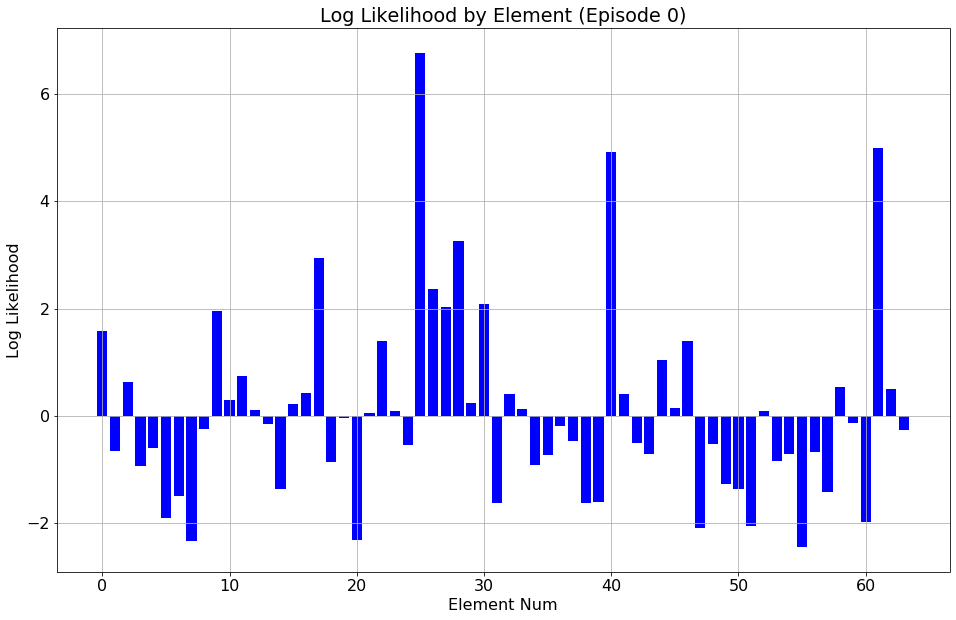

In [27]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [28]:
# Adaptive search parameters
max_batches_mixture = 2000
max_batches_element = 10000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = True
verbose = 1

In [29]:
# Load model
model.load()
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.19  : 188.99 :  1.000000 :  3600.00


In [30]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [31]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    save_at_end=True,
    verbose=verbose)


********************************************************************************
Terminating: Completed 10900 batches.
********************************************************************************
Saving candidate elements DataFrame in ../data/candidate_elt/candidate_elt_7003121184606232928.h5.


In [32]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.17  : 188.99 :  1.000000 :  3600.00


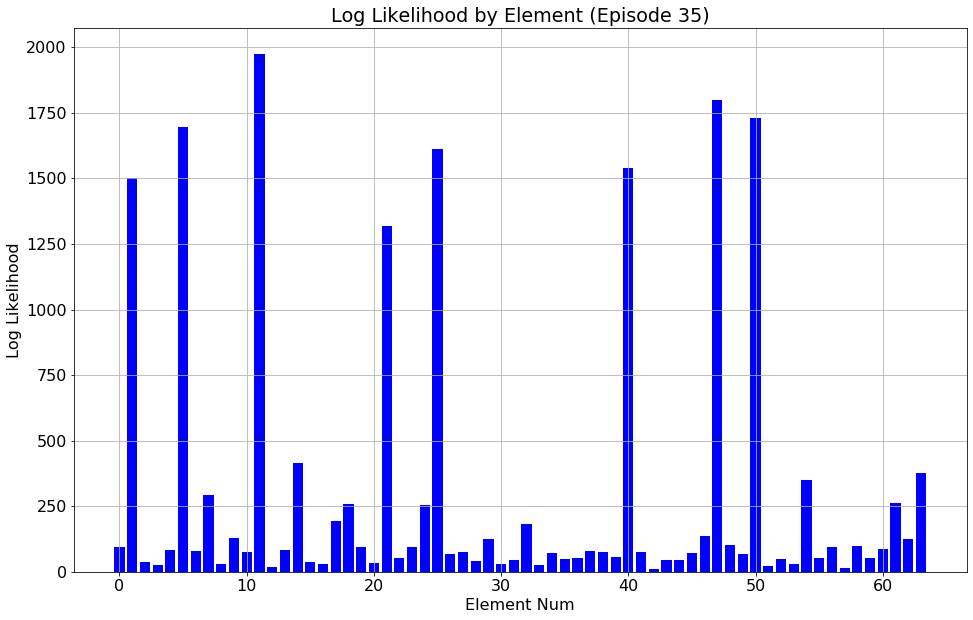

In [33]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

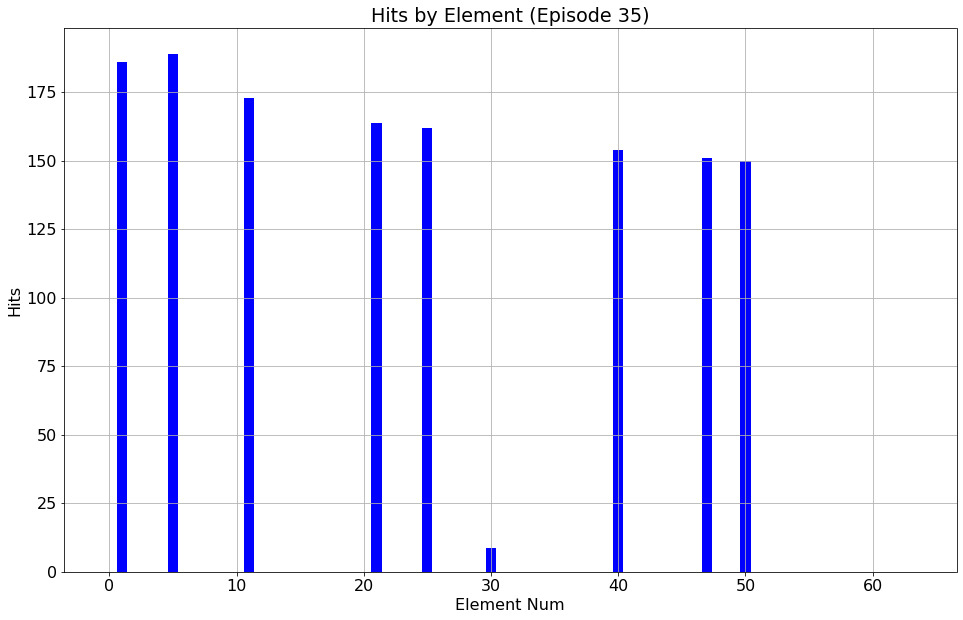

In [34]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('hits', sorted=False)

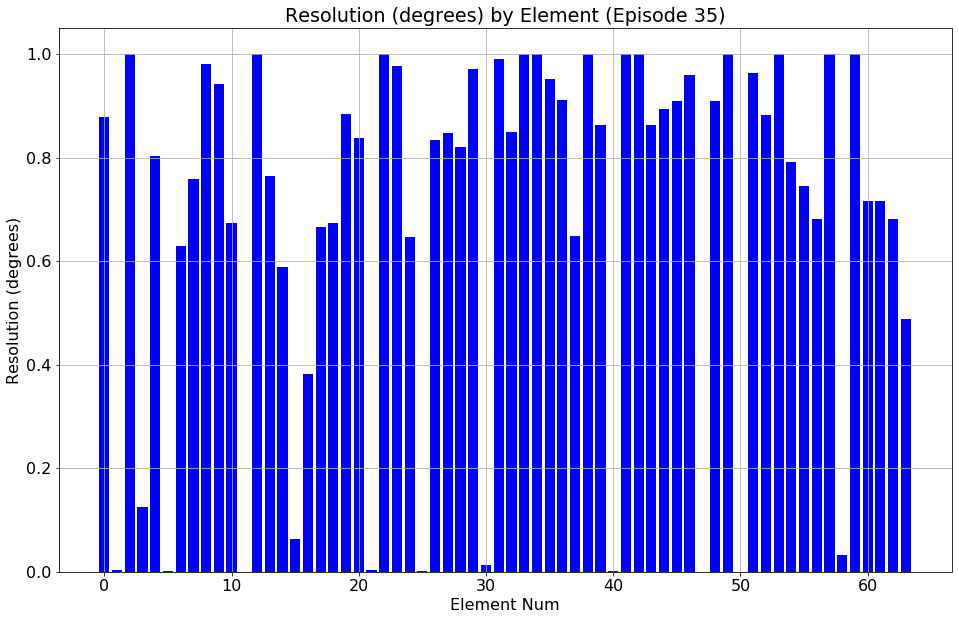

In [35]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('R_deg', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [36]:
# Unfreeze the elements, freeze the mixture model parameters
model.thaw_candidate_elements()

In [37]:
# New smaller learning rate
learning_rate = 2.0**-14

In [38]:
# Train unperturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    min_learning_rate=min_learning_rate,
    save_at_end=False,
    verbose=verbose)


********************************************************************************
Terminating: Completed 10900 batches.
********************************************************************************


In [39]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.18  : 188.99 :  1.000000 :  3600.00


In [40]:
model.save_state()

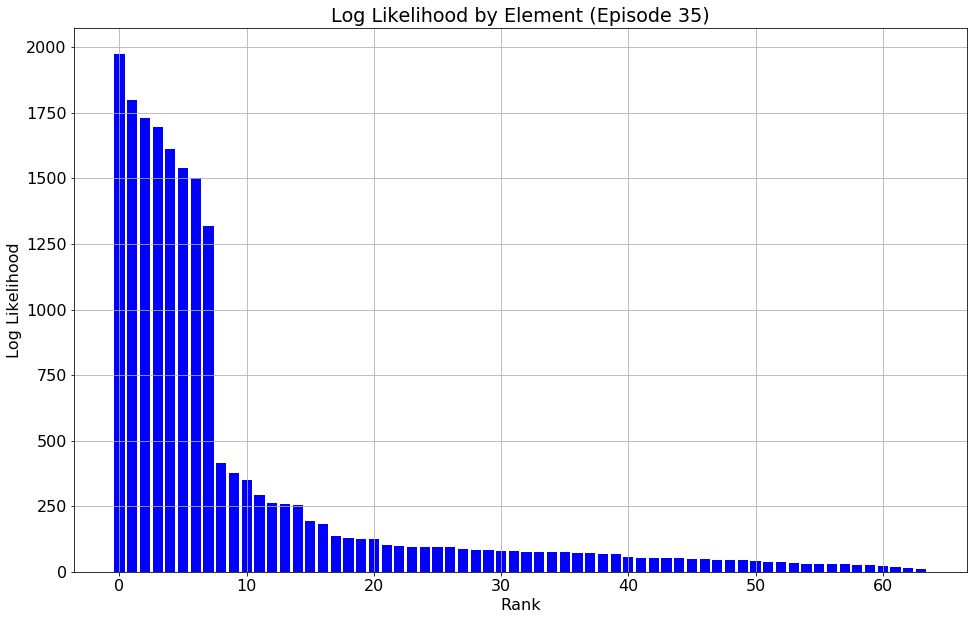

In [41]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Review Results Graphically

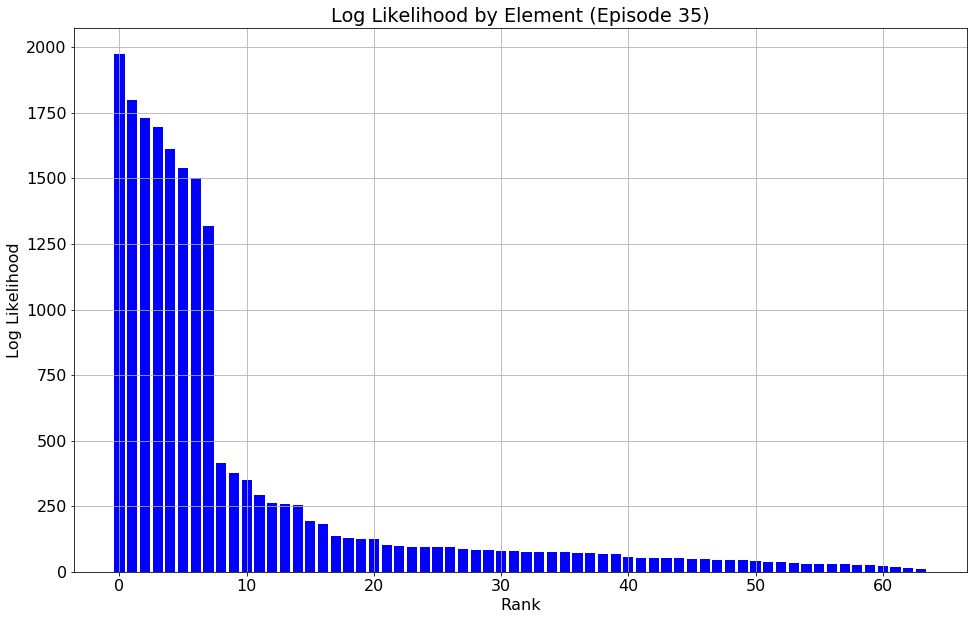

In [42]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

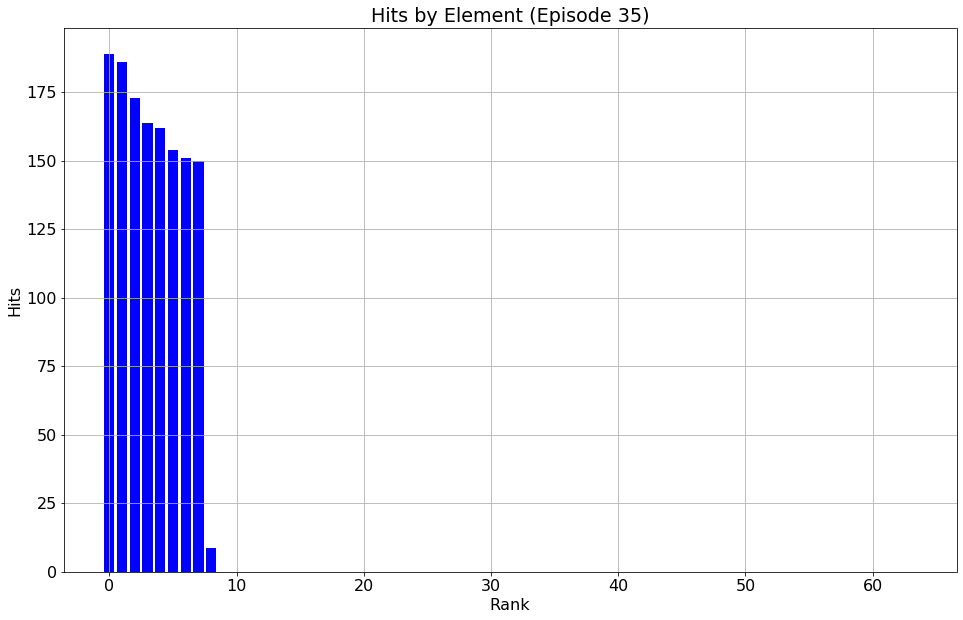

In [43]:
# Bar chart: hits
fig, ax = model.plot_bar('hits')

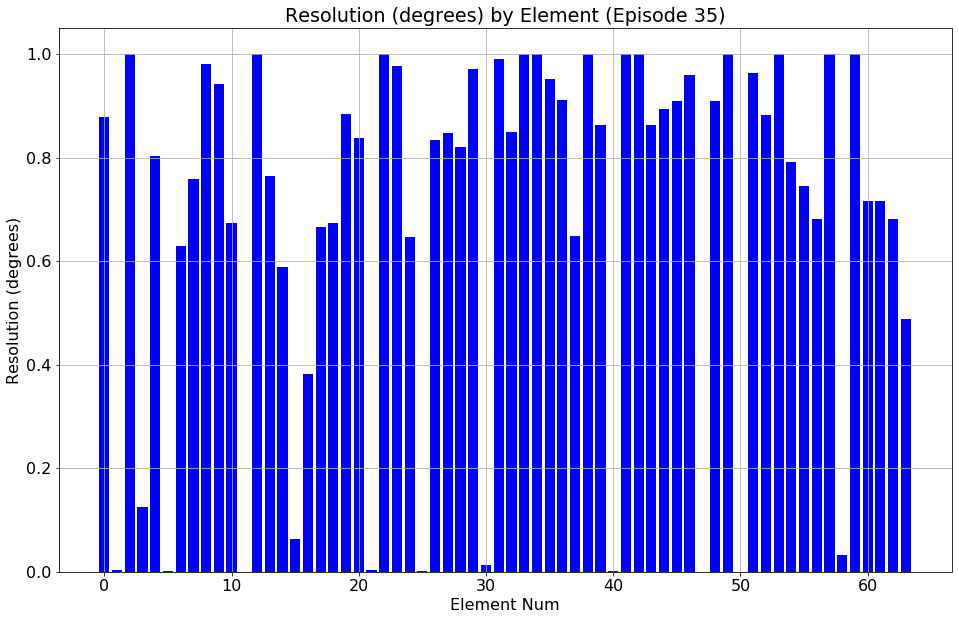

In [44]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('R_deg', sorted=False)

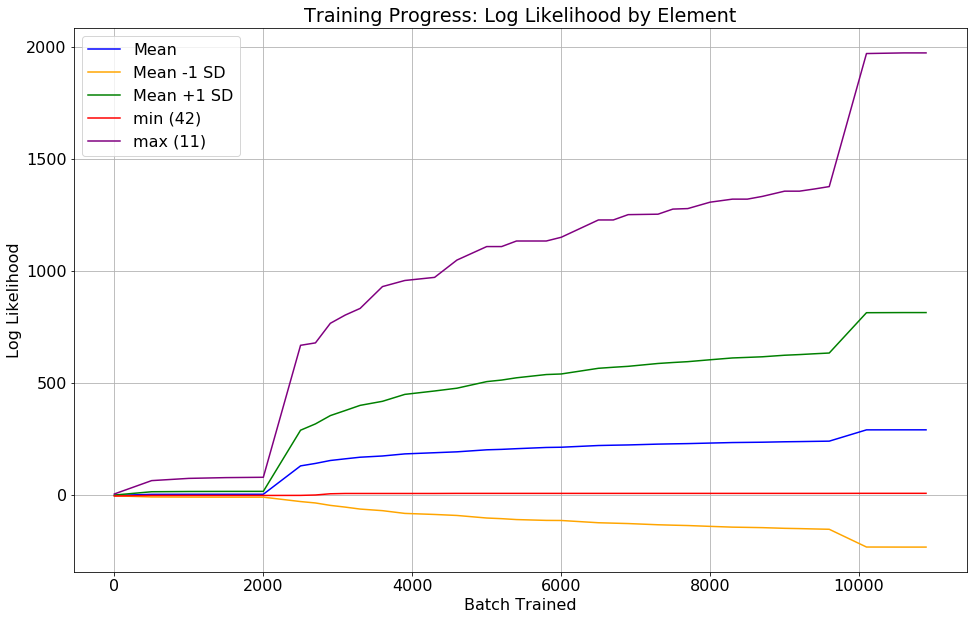

In [45]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

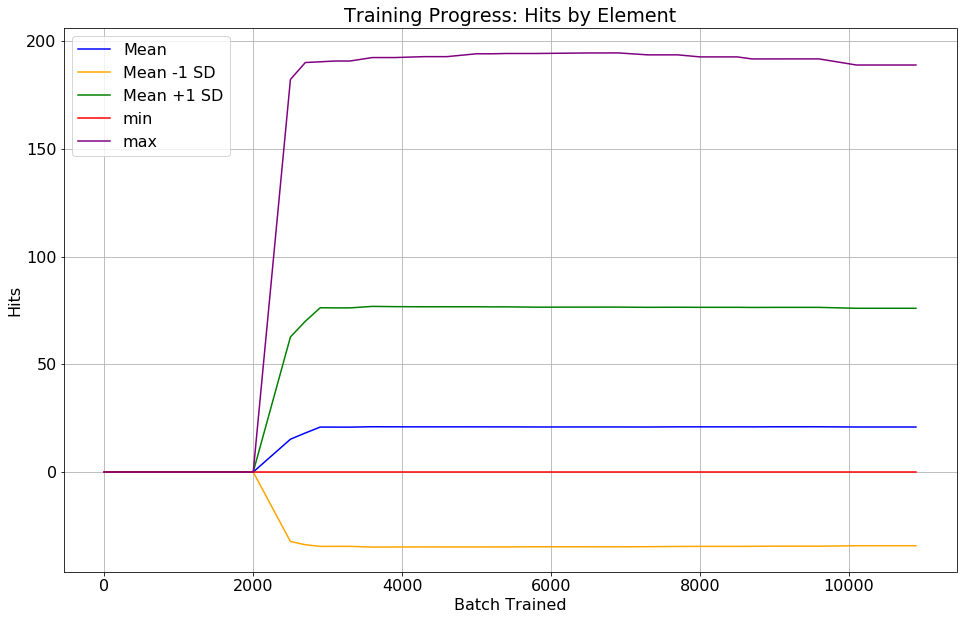

In [46]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Error vs. Nearest Asteroid

In [47]:
# The elements after fitting
elts_fit = model.candidates_df()

In [48]:
# Search for nearest asteroids to the fitted elements
elts_fit_near = nearest_ast_elt(elts_fit)

In [49]:
# Review asteroids nearest to the fitted elements
elts_fit_near

,element_id,asteroid_num,dist,asteroid_name,ast_a,ast_e,ast_inc,ast_Omega,ast_omega,ast_f,ast_epoch
element_id,,,,,,,,,,,
51921,51921,252633,0.010623,2001 XQ213,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
59244,59244,59244,0.000162,1999 CG6,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
15786,15786,433320,0.005603,2013 QS29,2.012032,0.053278,0.333170,0.158899,5.902577,-0.276670,58600.0
3904,3904,417240,0.006325,2005 YV117,2.865015,0.121253,0.167801,5.339624,1.921934,-0.945489,58600.0
142999,142999,306538,0.011572,1999 XY243,2.548402,0.199448,0.254083,6.083566,1.540373,-1.695064,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
11952,11952,400777,0.002879,2010 EF32,2.354203,0.084298,0.044560,0.406866,2.477171,-2.923987,58600.0
134815,134815,486319,0.009868,2013 CU114,2.425234,0.074032,0.268753,0.582630,0.913216,-1.538829,58600.0
27860,27860,521721,0.004585,2015 RA268,2.531813,0.143296,0.069150,5.607185,3.124851,-2.330678,58600.0


In [ ]:
# Index the nearest asteroid frame by element_id for easy operations with the candidate elements
ast_elt_nearest.set_index(keys='element_id', drop=False, inplace=True)

In [ ]:
ast_elt_nearest

In [ ]:
# Review fitted elements with nearest asteroid distance
elts_fit

In [ ]:
# Distance 

In [ ]:
# Calculate error vs. true elements
hist_err, q_err = model.calc_error(elts_fit_near)

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(elts_true=elts_ast, is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='e', is_log=True, elt_num=None)